# Hurricane tracts

This is a dataset I typically use for my Intro to Tableau workshop. I wanted to show how you could do the same visualizations in Altair that I cover there.

In [1]:
import pandas as pd
import altair as alt

## Read in hurricane tracts data

Specify that Season shouldn't be parsed as a number, even though it looks like that – keep as string

In [2]:
tracts = pd.read_excel('data/hurricane_tracts.xlsx', 
                       dtype={'Season':object})
tracts.dtypes

Longitude                float64
Latitude                 float64
Serial_Num                object
Season                    object
Num                        int64
Basin                     object
Sub_basin                 object
Hurricane Name            object
ISO_time                  object
Nature                    object
Wind in knots              int64
Pressure in millibars    float64
Wind Percentile          float64
Pressure Percentile      float64
Track_type                object
State                     object
SubRegion                 object
Region                    object
Country                   object
dtype: object

## Change ISO_time to a true date and time data type

and then check the types again

In [5]:
tracts['ISO_time'] = pd.to_datetime(tracts.ISO_time)
tracts.dtypes

Longitude                       float64
Latitude                        float64
Serial_Num                       object
Season                           object
Num                               int64
Basin                            object
Sub_basin                        object
Hurricane Name                   object
ISO_time                 datetime64[ns]
Nature                           object
Wind in knots                     int64
Pressure in millibars           float64
Wind Percentile                 float64
Pressure Percentile             float64
Track_type                       object
State                            object
SubRegion                        object
Region                           object
Country                          object
dtype: object

### Summary of the data statistics

In [6]:
tracts.describe()

,Longitude,Latitude,Num,Wind in knots,Pressure in millibars,Wind Percentile,Pressure Percentile
count,46933.000000,46933.000000,46933.000000,46933.000000,16672.000000,46933.000000,16672.000000
mean,-66.007266,26.902676,7.387744,53.266018,991.885437,50.661692,52.634471
std,19.361264,9.934079,5.260871,25.521932,19.240060,31.969774,29.944196
min,-118.300000,7.200000,1.000000,0.000000,882.000000,-100.000000,0.000000
25%,-81.100000,19.000000,3.000000,35.000000,984.000000,32.212000,26.462000
50%,-68.100000,26.300000,6.000000,50.000000,998.000000,57.961000,56.565000
75%,-53.000000,33.000000,10.000000,70.000000,1006.000000,78.425000,78.332000
max,28.000000,72.500000,31.000000,165.000000,1024.000000,99.997000,99.996000


## MaxRowsError

Can take off limit for number of rows, but that's not a great idea because the notebook will have a Vega-Lite JSON specification (text) embedded for every output pane, which also includes the data, so you end up with huge notebooks!

Instead, we can specify that the outputs should just refer to a JSON file on your local drive and load in the data from there for each plot.

See the Altair tutorial notebook `03-Binning-and-aggregation` for more details.

In [7]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Number of records per season bar chart

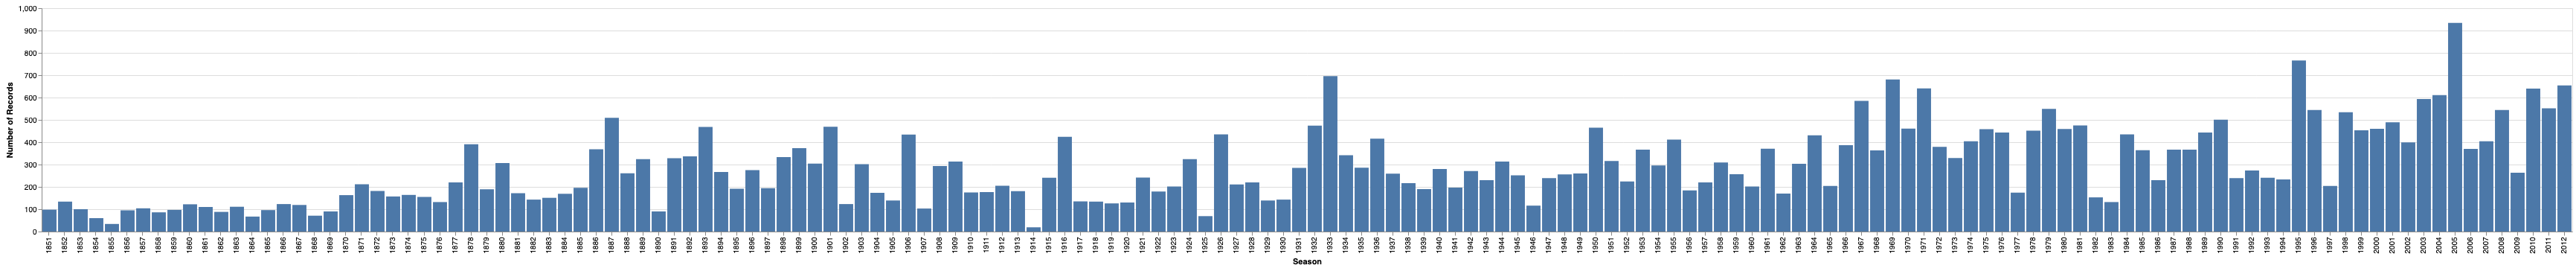

In [8]:
alt.Chart(tracts).mark_bar().encode(
    x = 'Season:O',
    y = 'count()'
)

## Vertical number of records per season

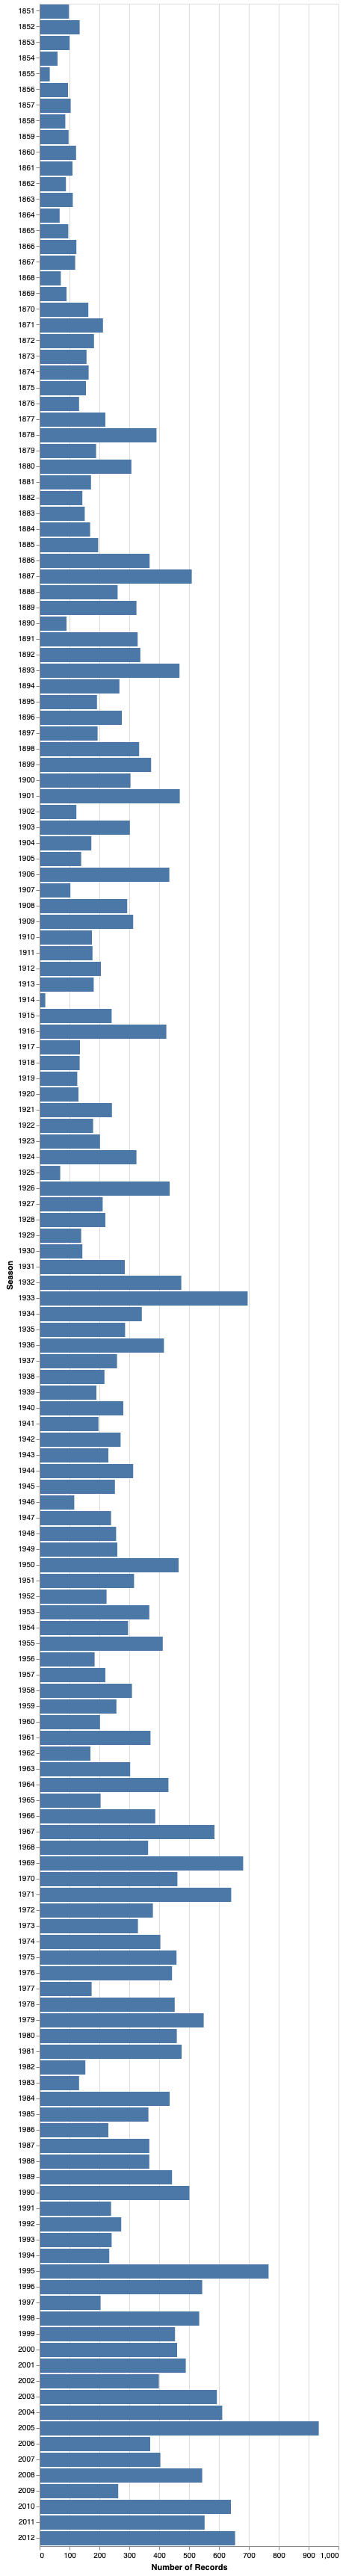

In [9]:
alt.Chart(tracts).mark_bar().encode(
    x = 'count()',
    y = 'Season:O'
)

## Sorted number of records per season

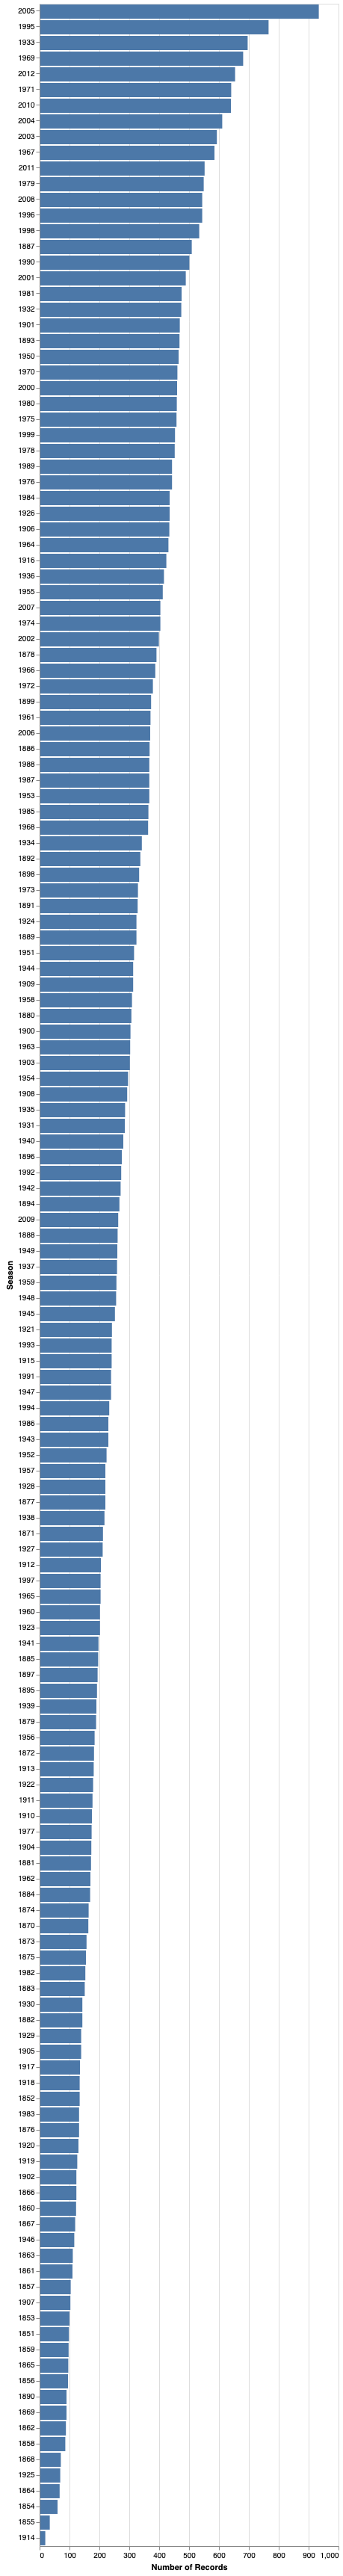

In [10]:
alt.Chart(tracts[['Season']]).mark_bar().encode(
    x='count():Q',
    y=alt.Y('Season:O',
        sort=alt.EncodingSortField(field='Season', 
                                   order='descending', 
                                   op='count')),
)

## Top 10 sorted number of records per season

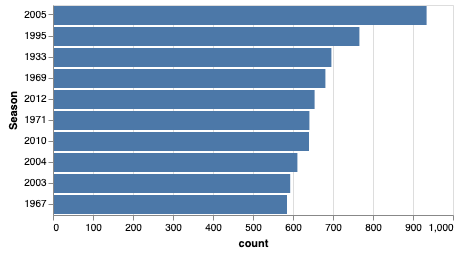

In [11]:
alt.Chart(tracts[['Season']]).mark_bar().encode(
    y=alt.Y('Season:O',
        sort=alt.EncodingSortField(field='count', order='descending', op='sum')),
    x='count:Q'
).transform_aggregate(
    count='count()',
    groupby=['Season']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 10')

## Sorted hurricanes per season

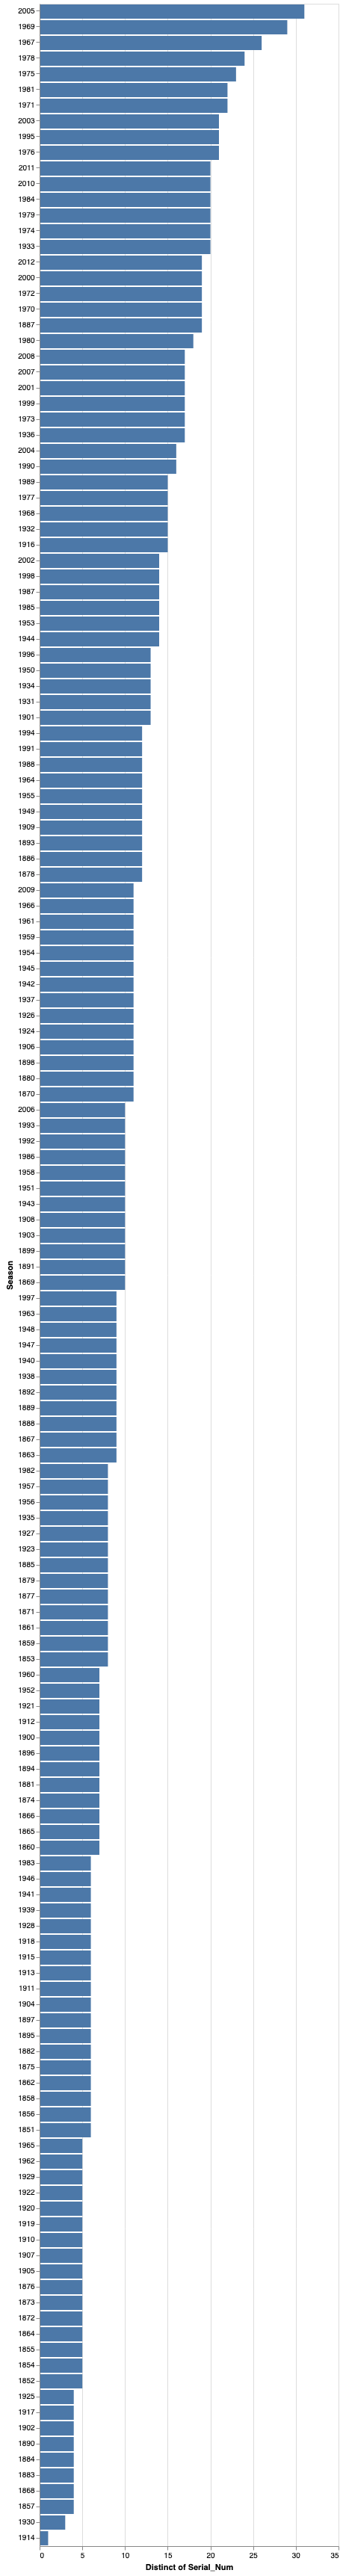

In [13]:
alt.Chart(tracts[['Season','Serial_Num']]).mark_bar().encode(
    y=alt.Y('Season:O',
        sort=alt.EncodingSortField(field='Serial_Num', order='descending', op='distinct')
           ),
    x='distinct(Serial_Num):Q'
)

## Top 10 hurricane seasons

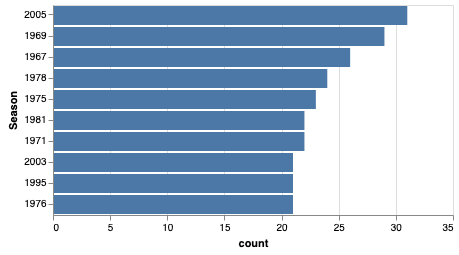

In [14]:
alt.Chart(tracts).mark_bar().encode(
    y=alt.Y('Season:O',
        sort=alt.EncodingSortField(field='count', order='descending', op='sum')),
    x='count:Q'
).transform_aggregate(
    count='distinct(Serial_Num)',
    groupby=['Season']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 10')

## Hurricane Season

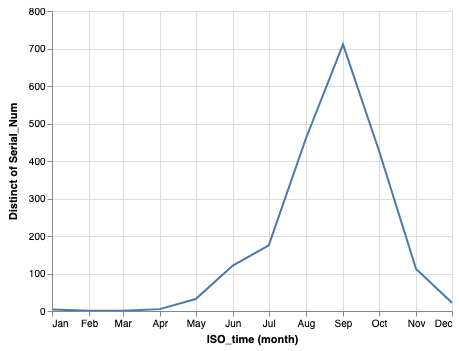

In [16]:
alt.Chart(tracts).mark_line().encode(
    x = 'month(ISO_time):T',
    y = 'distinct(Serial_Num):Q'
)

## Hurricanes per year timeline

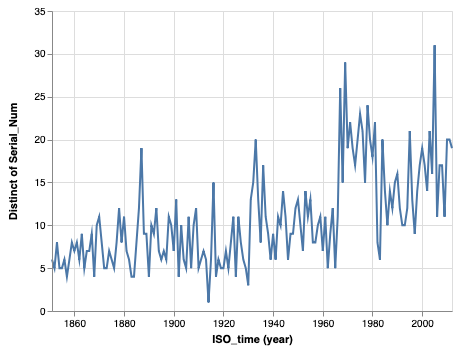

In [17]:
alt.Chart(tracts).mark_line().encode(
    x='year(ISO_time):T',
    y='distinct(Serial_Num):Q'
)

## Scatterplot

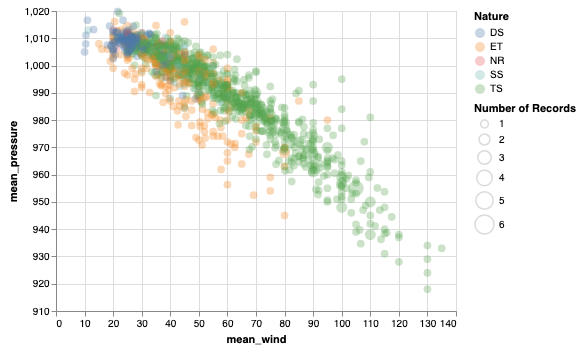

In [18]:
alt.Chart(tracts).mark_circle(opacity=0.3).encode(
    x='mean_wind:Q',
    y=alt.Y('mean_pressure:Q', scale=alt.Scale(zero=False)),
    size='count():Q',
    color='Nature:N'
).transform_filter(
    {"field":"Pressure in millibars", "gt":0}
).transform_aggregate(
    mean_wind='mean(Wind in knots)',
    mean_pressure='mean(Pressure in millibars)',
    groupby=['Serial_Num','Nature']
)

In [16]:
tracts.Nature.unique()

array(['TS', 'ET', 'SS', 'NR', 'DS'], dtype=object)

## Mapped tracts for 2005

In [17]:
# If you have vega_datasets installed

# from vega_datasets import data
# states = alt.topo_feature(data.us_10m.url, feature='states')

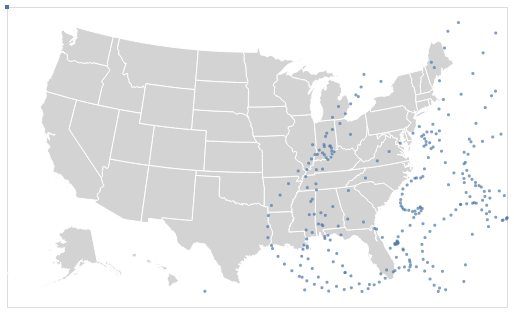

In [19]:
states = alt.topo_feature('https://vega.github.io/vega-datasets/data/us-10m.json', 
                          feature='states')

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa').properties(
    width=500,
    height=300
)

points = alt.Chart(tracts).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.value(10),
    tooltip='Hurricane Name'
).transform_filter(
    "datum.Season == 2005"
).project(
    "albersUsa"
).properties(
    width=500,
    height=400
)

background + points